# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv(r'C:\\Users\a.slivaev\Desktop\webinar_2\retail_train.csv')
item_features = pd.read_csv(r'C:\\Users\a.slivaev\Desktop\webinar_2\product.csv')
user_features = pd.read_csv(r'C:\\Users\a.slivaev\Desktop\webinar_2\hh_demographic.csv')

data = data[~data['user_id'].isin(['296', '1813', '1984', '2498'])]



# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83680 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[1106523, 899624, 871756, 1044078, 832678]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 15778319, 842125]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[820612, 1124971, 5574358, 1037135, 974265]

In [9]:
user = 2375
pd.DataFrame({
    'get_als_recommendations': [recommender.get_als_recommendations(user, N=5)],
    'get_own_recommendations': [recommender.get_own_recommendations(user, N=5)],
    'get_similar_items_morecommendation': [recommender.get_similar_items_recommendation(user, N=5)],
    'get_similar_users_recommendation': [recommender.get_similar_users_recommendation(user, N=5)]
}).T

,0
get_als_recommendations,"[1106523, 899624, 871756, 1044078, 832678]"
get_own_recommendations,"[948640, 918046, 847962, 907099, 873980]"
get_similar_items_morecommendation,"[1046545, 1044078, 937292, 15778319, 842125]"
get_similar_users_recommendation,"[820612, 1124971, 5574358, 1037135, 974265]"


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
result_lvl_1[result_lvl_1.user_id == 2375].T

,2041
user_id,2375
actual,"[835300, 848029, 862714, 896613, 923746, 93246..."


In [12]:
%%time
result_lvl_1['als_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(user=x, N=50))

Wall time: 19.6 s


In [13]:
%%time
result_lvl_1['own_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(user=x, N=50))

Wall time: 10.1 s


In [14]:
%%time
result_lvl_1['similar_items_rec-s'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(user=x, N=50))

Wall time: 13.6 s


In [15]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""

    popular = data.groupby(by='item_id')['sales_value'].sum().reset_index()
    popular.sort_values(by='sales_value', ascending=False, inplace=True)

    recs = popular.head(n).item_id

    return recs.tolist()

In [16]:
%%time
result_lvl_1['top-popular'] = result_lvl_1['user_id'].apply(lambda x: popularity_recommendation(data_train_lvl_1, n=50))

Wall time: 1min 7s


In [17]:
result_lvl_1['own+top'] = result_lvl_1['own_rec-s'] + result_lvl_1['top-popular']

In [18]:
result_lvl_1[result_lvl_1.user_id == 2375].T

,2041
user_id,2375
actual,"[835300, 848029, 862714, 896613, 923746, 93246..."
als_rec-s,"[1106523, 899624, 871756, 1044078, 832678, 100..."
own_rec-s,"[948640, 918046, 847962, 907099, 873980, 88469..."
similar_items_rec-s,"[1046545, 1044078, 937292, 15778319, 842125, 1..."
top-popular,"[999999, 1029743, 916122, 5569230, 1106523, 84..."
own+top,"[948640, 918046, 847962, 907099, 873980, 88469..."


In [21]:
def score_recomends(result_df):
    import pandas as pd
    from metrics import precision_at_k, recall_at_k
    df = pd.DataFrame(
        [
            (model_,
             round(result_df.apply(lambda row: precision_at_k(recommended_list=row[str(model_)], bought_list=row['actual']), axis=1).mean(), 5),
             round(result_df.apply(lambda row: recall_at_k(recommended_list=row[str(model_)], bought_list=row['actual']), axis=1).mean(), 5),
             ) for model_ in list(result_df)[2:]
        ], columns=['model', 'precision_at_k', 'recall_at_k']
    ).sort_values(by='precision_at_k', ascending=False)

    return df

In [22]:
score_recomends(result_df=result_lvl_1)

,model,precision_at_k,recall_at_k
1,own_rec-s,0.17721,0.01829
4,own+top,0.17721,0.01829
0,als_rec-s,0.11749,0.01324
3,top-popular,0.11284,0.01363
2,similar_items_rec-s,0.06586,0.00627


In [23]:
result_lvl_1_var_2 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

In [24]:
result_lvl_1_var_2.head(2).T

,0,1
user_id,1,2
actual,"[853529, 865456, 867607, 872137, 874905, 87524...","[15830248, 838136, 839656, 861272, 866211, 870..."


In [25]:
%%time
for k in [20, 50, 100, 200, 500, 750, 1000, 1500]:
    print(f'k={k}')
    result_lvl_1_var_2[f'similar_items_k={k}'] = \
        result_lvl_1_var_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(user=x, N=k))

k=20
k=50
k=100
k=200
k=500
k=750
k=1000
k=1500
Wall time: 3min 38s


In [26]:
result_lvl_1_var_2.head(1).T

,0
user_id,1
actual,"[853529, 865456, 867607, 872137, 874905, 87524..."
similar_items_k=20,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=50,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=100,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=200,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=500,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=750,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=1000,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."
similar_items_k=1500,"[884686, 1007512, 9297615, 5577022, 1061747, 1..."


In [27]:
k=750
result_lvl_1_var_2.apply(
    lambda row: recall_at_k(recommended_list=row[f'similar_items_k={k}'], bought_list=row['actual'], k=k), axis=1
).mean()

0.15945848406422428

In [28]:
recals_at_list_k = pd.DataFrame(
    [
        (
            k, 
            result_lvl_1_var_2.apply(
                lambda row: recall_at_k(
                    recommended_list=row[f'similar_items_k={k}'], bought_list=row['actual'], k=k), axis=1).mean()
        ) for k in [20, 50, 100, 200, 500, 750, 1000, 1500]
        
    ], columns={'k', 'value'}).sort_values(by='value', ascending=False)

recals_at_list_k

,k,value
7,1500,0.211775
6,1000,0.181213
5,750,0.159458
4,500,0.135708
3,200,0.084923
2,100,0.053590
1,50,0.033796
0,20,0.017772


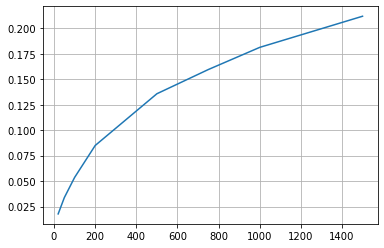

In [29]:
plt.plot(recals_at_list_k['k'],
         recals_at_list_k['value'])
plt.grid();

In [30]:
recals_at_list_k.head(1)

,k,value
7,1500,0.211775


Recall при k = 1500 показал наибольшее значение